# Формирование модели монетизации мобильной игры «Космические братья»

 **Основная Задача:**

Сформировать модель монетизации игрового приложения. Помочь бизнесу выбрать оптимальное время для запуска рекламы. Зная расходы на продвижение игры, посчитать окупаемость при разных сценариях.Провести исследовательский анализ данных. Проанализировать влияние событий на совершение целевого события. Проверить статистические гипотезы.


##  Предобработка данных

###  Импорт библиотек и загрузка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats as st
import seaborn as sns
from plotly import graph_objects as go
from pymystem3 import Mystem
m = Mystem()
import math as mth

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

from datetime import datetime, timedelta
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

In [2]:
actions = pd.read_csv('/datasets/game_actions.csv')
costs = pd.read_csv('/datasets/ad_costs.csv')
source = pd.read_csv('/datasets/user_source.csv') 

### Actions

In [3]:
display(actions)
actions.info()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


*Выводы:* 1. Нужно поменять формат данных у event_datetime. 2. Столбец project_type полностью не заполнен. 3. Есть пропуска в building_type

In [4]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null datetime64[ns]
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Столбец project_type полностью пуст - мы можем заполнить его, посмотрев для каждого пользователя, есть ли у него в event отметка finished_stage_1
или project. Однако я считаю это действие лишним - для того, чтобы дальше исследовать данные нам хватит столбца event. Удалим столбец из датафрейма

In [5]:
actions.drop('project_type', axis=1, inplace=True)

В столбце building_type мы встречаем пропуски в тех местах, где типа здания быть не может - действие игрока приводило к завершению уровня. Заменим эти пропуски на none

In [6]:
actions['building_type'] = actions['building_type'].fillna(value = 'none')

In [7]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 4 columns):
event_datetime    135640 non-null datetime64[ns]
event             135640 non-null object
building_type     135640 non-null object
user_id           135640 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.1+ MB


Удалим дубликаты

In [8]:
actions = actions.drop_duplicates()
actions = actions.dropna().reset_index(drop=True)
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 4 columns):
event_datetime    135639 non-null datetime64[ns]
event             135639 non-null object
building_type     135639 non-null object
user_id           135639 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.1+ MB


###  Costs

In [9]:
display(costs)
costs.info()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [10]:
costs['day'] = pd.to_datetime(costs['day'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null datetime64[ns]
cost      28 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


###  Source

In [11]:
display(source)
source.info()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


В этом датасете не пропусков и все форматы корректны. Начинаем исследовательский анализ данных

## Исследовательский анализ данных

### Количество уникальных игроков в датасете

In [12]:
all_players = len(actions['user_id'].unique())
all_players

13576

Мы исследуем выборку из 13576 игроков

### Какое количество действий совершают игроки

In [13]:
actions['user_id'].value_counts()

bf542075-e3a2-4e79-82d8-3838e86d2a25    22
d6aca06a-cd75-4cd8-b8cd-240a3c163884    22
ff841992-d93b-462e-bc6e-18c24a514f36    22
81fac0a1-fb17-4d48-90fe-50dc5e9ae5ab    21
c133dd1d-c5d0-48e8-aaf7-f654be5b9b56    21
                                        ..
4b1e7dfa-4bb6-427c-8356-b05e8da28e28     1
daea0325-f7c5-4008-b5f6-f89fc2c1e019     1
6c78f635-e4a9-435f-a2bb-154974d57646     1
48a96c0c-7c59-4f43-a694-58568b8c6820     1
f503e280-dfdd-439b-afcd-af93433aec42     1
Name: user_id, Length: 13576, dtype: int64

Самое большое количество действий, которое совершали игроки за рассматриваемый период времени - 22

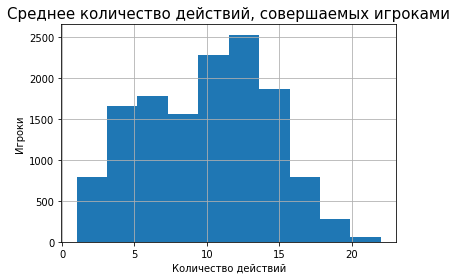

In [14]:
pivot = actions.pivot_table(index='user_id',values='event',aggfunc='count')
pivot.hist()
plt.title('Среднее количество действий, совершаемых игроками',size=15)
plt.xlabel('Количество действий')
plt.ylabel('Игроки');

В среднем наши пользователи совершают от 10 до 15 действий

### Какое количество пользователей прошло первый уровень

In [15]:
def final(event):
    
    if event == 'finished_stage_1':
        return 'yes'
    if event == 'project':
        return 'yes'
    else:
        return 'no'

actions['final']= actions['event'].apply(final)

winners = actions.loc[actions['final']=='yes']

finished_players = len(winners)
finished_players


7683

7683 прошли игру тем или иным способом

In [16]:
churn = (finished_players/all_players)
churn

0.5659251620506777

Первый уровень проходят 56.5% процентов пользователей. Это хороший показатель

### Как часто игроки выбирают пройти первый уровень с проектом или с победой над врагом?

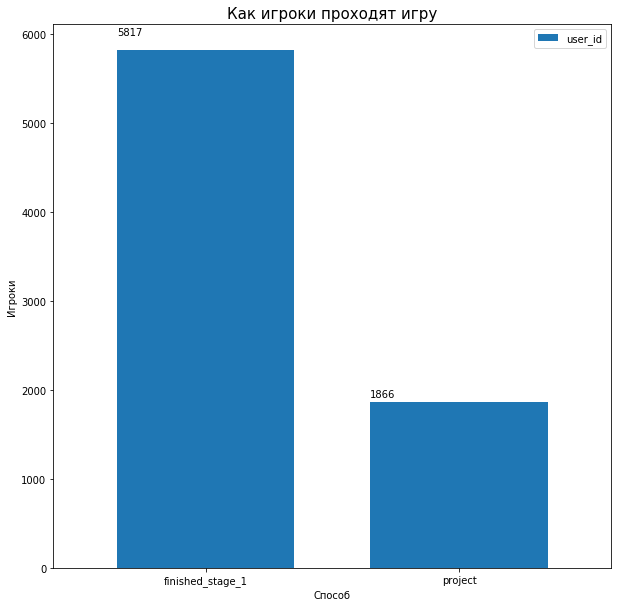

In [17]:
ax = winners.groupby(winners['event']).agg({'user_id': 'count'}).\
     plot.bar(figsize=(10, 10), rot=0, width=0.7)
plt.title('Как игроки проходят игру',size=15)
plt.xlabel('Способ')
plt.ylabel('Игроки');

for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
    
plt.show()

На графике видим, что в три раза больше игроков выбрали пройти уровень, уничтожив врага.

### Сколько времени проходит от первого действия игрока до завершения уровня?

In [18]:
#выделим первое время посещение игры
first_visit = actions.groupby('user_id')['event_datetime'].min() 
first_visit.name = 'first_session'
 
actions = pd.merge(actions, first_visit, on = 'user_id')
 
actions['first_session'] = pd.to_datetime(actions['first_session'])

#выделим последнее время посещение игры
last_visit = actions.groupby('user_id')['event_datetime'].max() 
last_visit.name = 'last_session'
 
actions = pd.merge(actions, last_visit, on = 'user_id')
 
actions['last_session'] = pd.to_datetime(actions['last_session'])

In [19]:
actions

,event_datetime,event,building_type,user_id,final,first_session,last_session
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01
...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,no,2020-05-10 23:57:56,2020-05-18 00:23:28
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,no,2020-05-10 23:57:56,2020-05-18 00:23:28
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,no,2020-05-10 23:59:52,2020-05-18 11:11:11
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,no,2020-05-10 23:59:52,2020-05-18 11:11:11


In [20]:
actions['duration'] = (actions['last_session'] - actions['first_session']).dt.days
actions

,event_datetime,event,building_type,user_id,final,first_session,last_session,duration
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6
...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,no,2020-05-10 23:57:56,2020-05-18 00:23:28,7
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,no,2020-05-10 23:57:56,2020-05-18 00:23:28,7
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,no,2020-05-10 23:59:52,2020-05-18 11:11:11,7
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,no,2020-05-10 23:59:52,2020-05-18 11:11:11,7


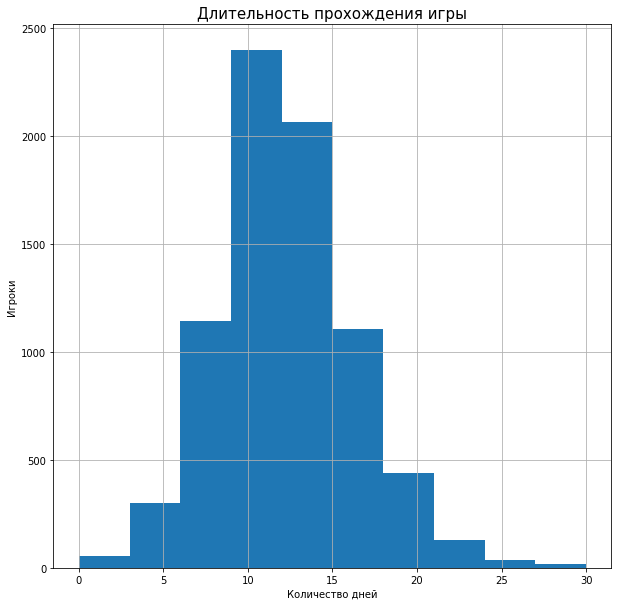

In [21]:
winners = actions.loc[actions['final']=='yes']
plt.figure(figsize=(10,10))
winners['duration'].hist()

plt.title('Длительность прохождения игры',size=15)
plt.xlabel('Количество дней')
plt.ylabel('Игроки');

In [22]:
winners['duration'].mean()

11.751008720551868

Большинство пользователей проходит игру за 12 дней

### Среднее время прохождение игры с разными способами

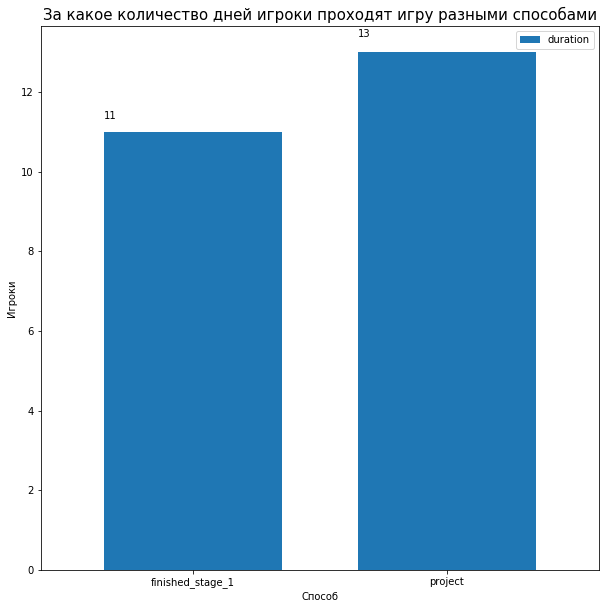

In [23]:
ax = winners.groupby(winners['event']).agg({'duration':'median'}).\
     plot.bar(figsize=(10, 10), rot=0, width=0.7)
plt.title('За какое количество дней игроки проходят игру разными способами',size=15)
plt.xlabel('Способ')
plt.ylabel('Игроки');

for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
    
plt.show()

### Анализ по источникам

#### Из какого источника пришло больше всего пользователей

In [24]:
source

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


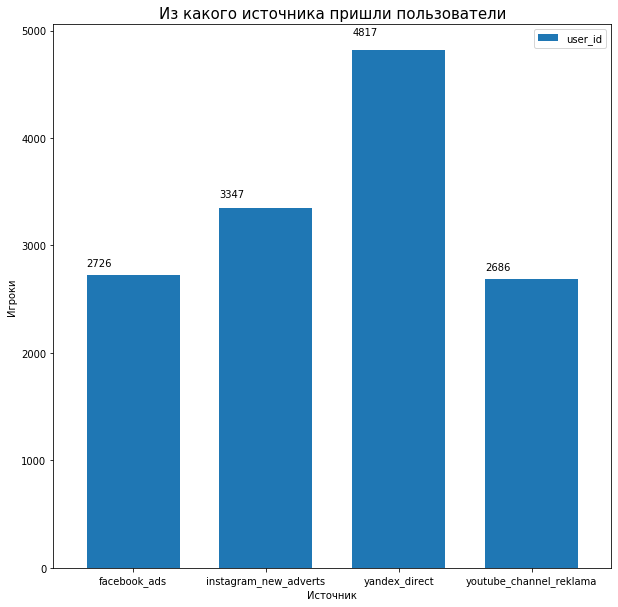

In [25]:
ax = source.groupby(source['source']).agg({'user_id':'count'}).\
     plot.bar(figsize=(10, 10), rot=0, width=0.7)
plt.title('Из какого источника пришли пользователи',size=15)
plt.xlabel('Источник')
plt.ylabel('Игроки');

for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
    
plt.show()

Через контекстную рекламу яндекс директ пришло больше всего игроков

#### Стоимость рекламы на различных площадках

In [26]:
costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


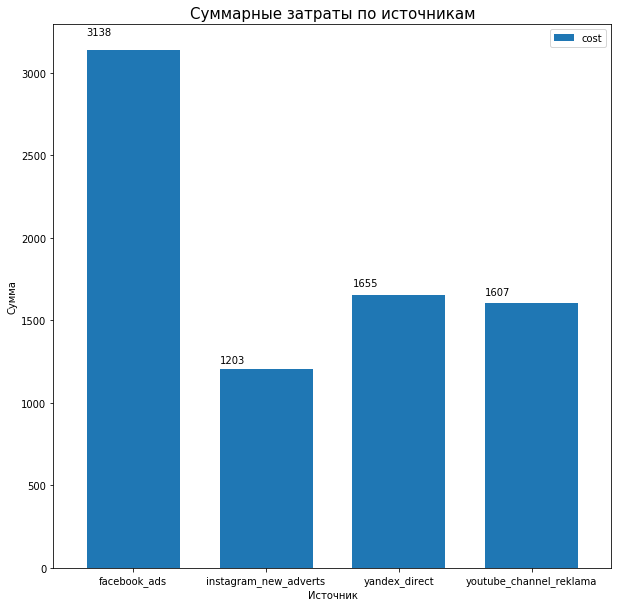

In [27]:
ax = costs.groupby(source['source']).agg({'cost':'sum'}).\
     plot.bar(figsize=(10, 10), rot=0, width=0.7)
plt.title('Суммарные затраты по источникам',size=15)
plt.xlabel('Источник')
plt.ylabel('Сумма');

for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
    
plt.show()

#### CAC по источникам

In [28]:
actions['day'] = actions['first_session'].dt.date
actions['day'] = pd.to_datetime(actions['day'])
report = actions[['day','user_id']]
report

,day,user_id
0,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
1,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
2,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
3,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
4,2020-05-04,55e92310-cb8e-4754-b622-597e124b03de
...,...,...
135634,2020-05-10,cafd1b8b-507b-49ae-abf0-89fe863a8b03
135635,2020-05-10,cafd1b8b-507b-49ae-abf0-89fe863a8b03
135636,2020-05-10,bdc53e19-462a-4dc3-8b55-b4a34278af6a
135637,2020-05-10,bdc53e19-462a-4dc3-8b55-b4a34278af6a


In [29]:
report2 = source.merge(report, on='user_id', how='left')
report2 

,user_id,source,day
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
...,...,...,...
135634,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,2020-05-08
135635,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,2020-05-08
135636,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,2020-05-08
135637,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,2020-05-08


In [30]:
report3 = report2.groupby(['day', 'source']).agg({'user_id':'nunique'}).reset_index()
report3 = report3.rename(columns = {'user_id':'cnt_users'})
report3

,day,source,cnt_users
0,2020-05-04,facebook_ads,1184
1,2020-05-04,instagram_new_adverts,1452
2,2020-05-04,yandex_direct,2078
3,2020-05-04,youtube_channel_reklama,1146
4,2020-05-05,facebook_ads,694
5,2020-05-05,instagram_new_adverts,796
6,2020-05-05,yandex_direct,1208
7,2020-05-05,youtube_channel_reklama,663
8,2020-05-06,facebook_ads,345
9,2020-05-06,instagram_new_adverts,472


In [31]:
costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [32]:
cac = report3.merge(costs, on=['day','source'], how='left')
cac['cac'] = (cac['cost'] / cac['cnt_users']).round(2)
cac

,day,source,cnt_users,cost,cac
0,2020-05-04,facebook_ads,1184,548.354480,0.46
1,2020-05-04,instagram_new_adverts,1452,502.925451,0.35
2,2020-05-04,yandex_direct,2078,554.651494,0.27
3,2020-05-04,youtube_channel_reklama,1146,259.073224,0.23
4,2020-05-05,facebook_ads,694,260.185754,0.37
5,2020-05-05,instagram_new_adverts,796,313.970984,0.39
6,2020-05-05,yandex_direct,1208,308.232990,0.26
7,2020-05-05,youtube_channel_reklama,663,147.041741,0.22
8,2020-05-06,facebook_ads,345,177.982200,0.52
9,2020-05-06,instagram_new_adverts,472,173.071145,0.37


Данных за 10 мая у нас нет, так как в этот день реклама уже не запускалась и деньги на нее не тратились

In [33]:
cac = cac.query('day != "2020-05-10"')

In [34]:
cac_sources_piv = cac.pivot_table(index='day', columns='source', values='cac', aggfunc='sum')
cac_sources_piv

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-04,0.46,0.35,0.27,0.23
2020-05-05,0.37,0.39,0.26,0.22
2020-05-06,0.52,0.37,0.27,0.24
2020-05-07,0.50,0.41,0.29,0.25
2020-05-08,0.49,0.41,0.26,0.30
2020-05-09,0.46,0.42,0.30,0.23


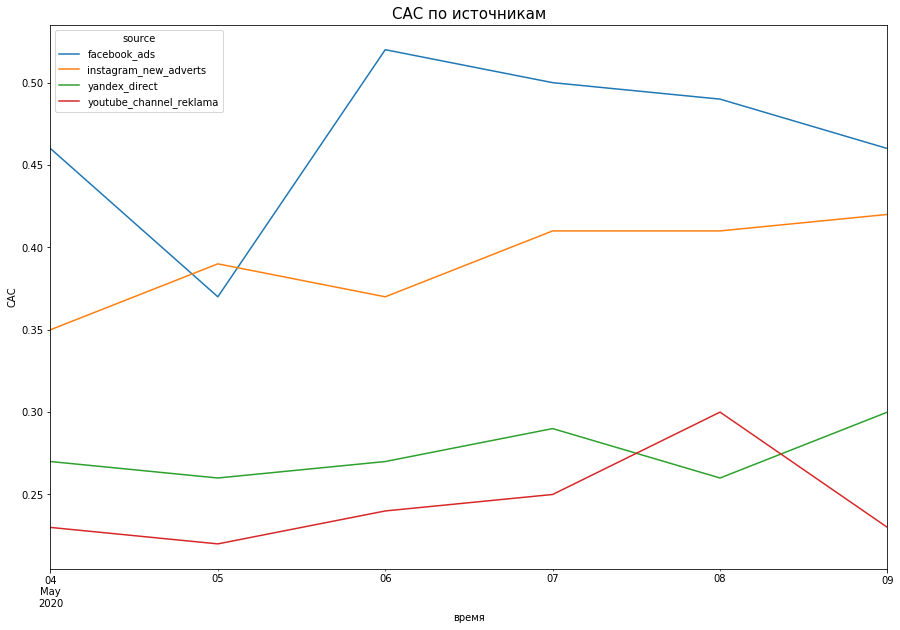

In [35]:
cac_sources_piv.plot(figsize=(15,10))
plt.title('САС по источникам',size=15)
plt.xlabel('время')
plt.ylabel('САС');

Рассчитаем средний CAC по источникам

In [36]:
cac_pivot = cac.pivot_table(index='source', values = 'cac', aggfunc = 'mean')

cac_facebook = cac_pivot.query('source == "facebook_ads"')
cac_facebook = cac_facebook['cac']

cac_instagram = cac_pivot.query('source == "instagram_new_adverts"')
cac_instagram = cac_instagram['cac']

cac_yandex = cac_pivot.query('source == "yandex_direct"')
cac_yandex = cac_yandex['cac']

cac_youtube = cac_pivot.query('source == "youtube_channel_reklama"')
cac_youtube = cac_youtube['cac']

## Проверка гипотез

### Гипотеза: время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, отличается от времени прохождения уровня пользователями, которые заканчивают уровень победой над другим игроком

Нулевая гипотеза: игроки тратят одинаковое количество времени на прохождение уровня обоими способами. Альтернативная: игроки затрачивают разное время на прохождение уровня

In [37]:
research = winners.loc[winners['event']=='project']
researchers = research['duration']
fight = winners.loc[winners['event']=='finished_stage_1']
fighters = fight['duration']

In [38]:
alpha = 0.05 #крит уровень стат значимости, еслм p-value меньше то гипотезу отвергаем

results = st.ttest_ind(
    fighters, 
    researchers,
equal_var = False)

print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.38119271253851e-58
Отвергаем нулевую гипотезу


Результаты проверки показали, что игроки тратят разное количество времени на прохождение уровня обоими способами. Ранее мы выяснили, что игроки, заканчивающие уровень через проект, тратят больше времени

### Гипотеза: средний CAC по источникам яндекс и ютуб равен

Нулевая гипотеза: средний CAC по источникам яндекс и ютуб равен. Альтернативная: средний CAC по источникам яндекс и ютуб не равен

In [39]:
yandex = cac.loc[cac['source']=='yandex_direct']
youtube = cac.loc[cac['source']=='youtube_channel_reklama']
youtube = youtube['cac']
yandex = yandex['cac']

In [40]:
alpha = 0.05 #крит уровень стат значимости, еслм p-value меньше то гипотезу отвергаем

results = st.ttest_ind(
    yandex, 
    youtube,
equal_var = False)

print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.05781228090196656
Не получилось отвергнуть нулевую гипотезу


У нас не получилось отвергнуть нулевую гипотезу - значит, стоимость клика по источникам яндекс и ютуб примерно равна. Мы можем указать эти источники, как самые лучшие в соотношении цена-количество новых игроков

## Модель монетезации

### Постройка зданий

наши пользователи строили здания. Посмотрим, какие из них строили чаще

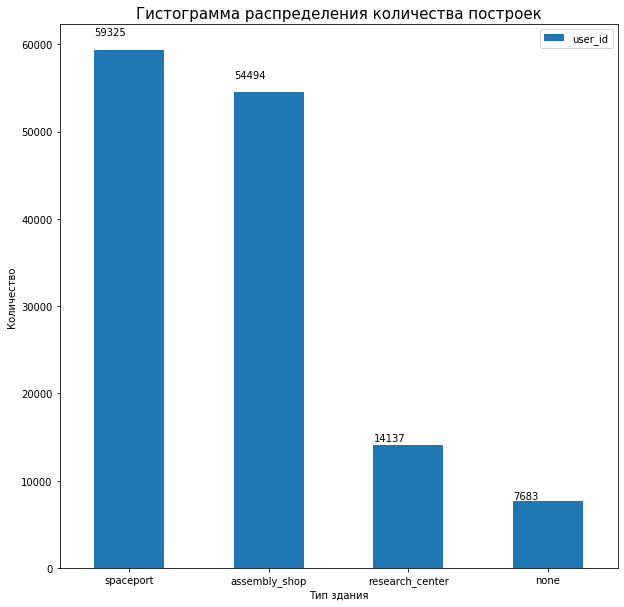

In [41]:
pivot4 = actions.pivot_table(index='building_type',values='user_id',aggfunc='count')
pivot4 = pivot4.sort_values(by='user_id',ascending=False)
ax = pivot4.plot(figsize=(10, 10),kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
plt.xticks(rotation=360) 
plt.title('Гистограмма распределения количества построек',size=15)
plt.xlabel('Тип здания')
plt.ylabel('Количество');

Лидирующее здание - космопорт. Незначительно меньше игроки строили сборочный цех. Можно сделать эти постройки целевыми событиями. Посчитаем, сколько раз за игру пользователи строят здания

In [42]:
df = actions.pivot_table(index='user_id', values='building_type', aggfunc='count')
pokaz = df['building_type'].mean()
print(pokaz)
print(df['building_type'].median())
print(df)

9.991087212728344
10.0
                                      building_type
user_id                                            
0001f83c-c6ac-4621-b7f0-8a28b283ac30             13
00151b4f-ba38-44a8-a650-d7cf130a0105              9
001aaea6-3d14-43f1-8ca8-7f48820f17aa              4
001d39dc-366c-4021-9604-6a3b9ff01e25              9
002f508f-67b6-479f-814b-b05f00d4e995             12
...                                             ...
ffef4fed-164c-40e1-bde1-3980f76d0fb5             10
fffab3da-da0e-4e30-ae62-10d0a2e24a4e             16
fffb626c-5ab6-47c9-8113-2062a2f18494             10
ffff194a-56b7-4c12-860d-3485242ae7f5              7
ffff69cc-fec1-4fd3-9f98-93be1112a6b8             14

[13576 rows x 1 columns]


10 построек сделает средний пользователь во время прохождение первого уровня. Значит, рекламу мы покажем 10 раз. Ранее мы получили, что игру проходит до первого уровня 57%. Это люди, которые увидят рекламу. 

In [43]:
#финансовая модель, чтобы выйти в ноль

# чтобы посчитать окупаемость на одном пользователе, будем считать прибыль как:
# 1(один пользователь) *1-churn(процент оттока) * x (количество просмотренной рекламы) * y (прибыль которую принес пользователь (0.1-0.07)
# и будем сравнивать с cac_yandex, cac_youtube, cac_facebook, cac_instagram


def model_yandex(y,x,z):
    return z*x*y >= cac_yandex
    
def model_youtube(y,x,z):
    return z*x*y >= cac_youtube

def model_facebook(y,x,z):
    return z*x*y >= cac_facebook

def model_instagram(y,x,z):
    return z*x*y >= cac_instagram



In [44]:
y = [0.07, 0.08, 0.09, 0.1]
x = 10
z = 1-churn
for i in y:
    print(model_yandex(i, x,z))
    print(model_youtube(i,x,z))
    print(model_facebook(i,x,z))
    print(model_instagram(i,x,z))

source
yandex_direct    True
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    True
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    True
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    True
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    True
Name: cac, dtype: bool


При заданных параметрах игра окупается даже не смотря на показатели Facebook. Теперь посмотрим, что будет, если мы будем показывать рекламу только один раз при первом заходе на главный экран

In [45]:
y = [0.07, 0.08, 0.09, 0.1]
x = 1
z = 1 - churn
for i in y:
    print(model_yandex(i, x,z))
    print(model_youtube(i,x,z))
    print(model_facebook(i,x,z))
    print(model_instagram(i,x,z))

source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool


В этом случае игра не окупится. Посмотрим, что будет, если пользователей станет раздражать реклама и отток увеличится до 70% :

In [46]:
y = [0.07, 0.08, 0.09, 0.1]
x = 10
z = 0.3
for i in y:
    print(model_yandex(i, x,z))
    print(model_youtube(i,x,z))
    print(model_facebook(i,x,z))
    print(model_instagram(i,x,z))

source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    False
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    False
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool
source
yandex_direct    True
Name: cac, dtype: bool
source
youtube_channel_reklama    True
Name: cac, dtype: bool
source
facebook_ads    False
Name: cac, dtype: bool
source
instagram_new_adverts    False
Name: cac, dtype: bool


Тоже не окупается. Чтобы выходить в ноль/получать прибыль, нам нужно удерживать 57% пользователей и показывать рекламу при каждом заходе в выбор объекта постройки

## Выводы

Мы проанализировали выборку из 13576 игроков, пришедших в игру в период с 4 по 9 мая 2020. Данные показали, что:

1) Максимум действий, которые совершают игроки - 22. Среднее количество действий в игре - 10-15.

2) Первый уровень прошло 7683 человек, или 57% от числа пришедших в игру

3) Из прошедших первый уровень в 3 раза чаще игроки выбирали прохождение через победу над врагом

4) В среднем игроки проходили 1 уровень за 12 дней. При этом те, кто проходил уровень через проект, проходили его дольше чем те, кто побеждал врага

5) Больше всего новых пользователей привлек канал "Яндекс". У этого канала и канала "Ютуб" самый лучший показатель CAC

6) Меньше всего пользователей привлек канал "Инстаграм" - вероятно, целева аудитория пользователей игры "Космические братья"находится не там

7) Средний пользователь делает 10 построек за игру

**Рекомендации**

Игроки проходят первый уровень в среднем 12 дней и за это время 10 раз увидят рекламу при выборе постройки здания. Такое количество не должно отпугнуть пользователей. Если показывать рекламу меньше раз, то прибыль не будет превышать доход на рекламу, а большее количество может отпугнуть. Чтобы выходить в ноль/получать прибыль, нам нужно удерживать 57% пользователей и показывать рекламу при каждом заходе в выбор объекта постройки

Чтобы находить игроков своей ЦА, рекомендую делать упор на каналы "Яндекс" и "Ютуб"

Презентация: https://drive.google.com/file/d/15IrpwbJJ6IMAQK572mj2zAU_TIYSNtjK/view?usp=sharing

Cсылка на дашборд (набор 1): https://public.tableau.com/app/profile/ekaterina.primaka/viz/space_16221997866880/Dashboard1

In [48]:
def user_type(event):
    
    if event == 'finished_stage_1':
        return 'fighters'
 
    else:
        return 'researchers'

winners['user_type']= winners['event'].apply(user_type)

user_type = winners[['user_id','user_type']]
user_type 

,user_id,user_type
17,c07b1c10-f477-44dc-81dc-ec82254b1347,researchers
19,c07b1c10-f477-44dc-81dc-ec82254b1347,fighters
32,6edd42cc-e753-4ff6-a947-2107cd560710,fighters
49,cdc6bb92-0ccb-4490-9866-ef142f09139d,fighters
73,4fe0f101-694b-4e31-9740-d1d87f7208ea,fighters
...,...,...
135534,825e727b-7847-4c5f-a26c-3ee0f18d8177,fighters
135586,637a8d39-3872-4549-80cc-bebee6c88056,researchers
135587,637a8d39-3872-4549-80cc-bebee6c88056,fighters
135609,0d37a895-ee0f-4e36-aadb-880cef670f0b,fighters


In [49]:
dash = actions.merge(user_type, on='user_id', how='left')
dash['user_type'] = dash['user_type'].fillna(value = 'not finished')
dash.head(50)

,event_datetime,event,building_type,user_id,final,first_session,last_session,duration,day,user_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
5,2020-05-08 08:16:51,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
6,2020-05-10 20:27:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,no,2020-05-04 00:00:01,2020-05-10 20:27:01,6,2020-05-04,not finished
7,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,no,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04,researchers
8,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,no,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04,fighters
9,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,no,2020-05-04 00:00:03,2020-05-15 05:29:13,11,2020-05-04,researchers


In [50]:
dash.to_csv('dash.csv')

Дашборд 2: https://public.tableau.com/app/profile/ekaterina.primaka/viz/spacebro2/Dashboard1